In [2]:
import json
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from scipy import integrate

In [3]:
FILE_PATH = '/mnt/sda3/dataset_AMC /radioml2018/versions/2/GOLD_XYZ_OSC.0001_1024.hdf5'
JSON_PATH = '/mnt/sda3/dataset_AMC /radioml2018/versions/2/classes-fixed.json'

In [10]:
def load_radioml_metadata(file_path):
    """Load only the metadata (labels) without the signal data"""
    try:
        # Try HDF5 format first
        if file_path.endswith('.hdf5') or file_path.endswith('.h5'):
            with h5py.File(file_path, 'r') as f:
                print("Available keys in HDF5 file:", list(f.keys()))
                Y = f['Y'][:]  # Load labels only
                Z = f['Z'][:]  # Load SNR labels only
                total_samples = f['X'].shape[0]  # Get shape without loading data
                return Y, Z, total_samples, 'hdf5'
        
        # Try pickle format
        elif file_path.endswith('.pkl'):
            with open(file_path, 'rb') as f:
                data = pickle.load(f, encoding='latin1')
                
            if isinstance(data, dict):
                print("Available keys in pickle file:", list(data.keys()))
                # Common key variations in RadioML datasets
                if 'snrs' in data and 'mods' in data:
                    # This is the format with separate arrays
                    X_key = next(k for k in data.keys() if k not in ['snrs', 'mods'])
                    return data['mods'], data['snrs'], len(data[X_key]), 'pkl_dict'
                elif 'Y' in data and 'Z' in data:
                    return data['Y'], data['Z'], len(data['X']), 'pkl_standard'
            else:
                # Assume it's a tuple (X, lbl) format
                X, lbl = data
                return lbl, None, len(X), 'pkl_tuple'
                
    except Exception as e:
        print(f"Error loading metadata: {e}")
        return None, None, 0, None

In [11]:
def load_specific_samples(file_path, indices, file_format):
    """Load only specific samples by index"""
    try:
        if file_format == 'hdf5':
            with h5py.File(file_path, 'r') as f:
                # Load only the requested indices
                X_samples = f['X'][indices, :, :]
                return X_samples
        
        elif file_format in ['pkl_dict', 'pkl_standard']:
            with open(file_path, 'rb') as f:
                data = pickle.load(f, encoding='latin1')
            
            if file_format == 'pkl_dict':
                X_key = next(k for k in data.keys() if k not in ['snrs', 'mods'])
                X_samples = np.array([data[X_key][i] for i in indices])
            else:
                X_samples = np.array([data['X'][i] for i in indices])
            
            return X_samples
        
        elif file_format == 'pkl_tuple':
            with open(file_path, 'rb') as f:
                data = pickle.load(f, encoding='latin1')
            X, _ = data
            X_samples = np.array([X[i] for i in indices])
            return X_samples
            
    except Exception as e:
        print(f"Error loading specific samples: {e}")
        return None

In [12]:
def find_samples_by_mod_snr_efficient(modulation, snr_db, Y, Z, max_samples=5, total_samples=None):
    """Find sample indices for specific modulation and SNR - memory efficient"""
    
    # Handle different label formats
    if isinstance(Y[0], str):
        # String labels format
        mod_matches = np.where(np.array(Y) == modulation)[0]
        snr_matches = np.where(np.array(Z) == snr_db)[0] if Z is not None else np.arange(len(Y))
    elif len(Y.shape) == 2:
        # One-hot encoded format
        if modulation not in MODULATION_CLASSES:
            raise ValueError(f"Modulation {modulation} not in dataset. Available: {MODULATION_CLASSES}")
        
        mod_idx = MODULATION_CLASSES.index(modulation)
        snr_idx = SNR_RANGE.index(snr_db) if snr_db in SNR_RANGE else None
        
        mod_matches = np.where(Y[:, mod_idx] == 1)[0]
        if Z is not None and snr_idx is not None:
            snr_matches = np.where(Z[:, snr_idx] == 1)[0]
        else:
            snr_matches = np.arange(len(Y))
    else:
        # Label encoded format
        mod_idx = MODULATION_CLASSES.index(modulation) if modulation in MODULATION_CLASSES else None
        snr_idx = SNR_RANGE.index(snr_db) if snr_db in SNR_RANGE else None
        
        mod_matches = np.where(Y == mod_idx)[0] if mod_idx is not None else []
        snr_matches = np.where(Z == snr_idx)[0] if Z is not None and snr_idx is not None else np.arange(len(Y))
    
    # Find intersection
    matching_indices = np.intersect1d(mod_matches, snr_matches)
    
    print(f"Found {len(matching_indices)} samples for {modulation} at {snr_db} dB")
    
    return matching_indices[:max_samples]

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy import integrate
import pickle

# ===============================
# RadioML2018.A Dataset Information
# ===============================
MODULATION_CLASSES = [
    'OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK',
    '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM',
    '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC',
    'FM', 'GMSK', 'OQPSK'
]

SAMPLE_RATE = 200e3  # 200 kHz
SAMPLES_PER_FRAME = 1024
SNR_RANGE = list(range(-20, 32, 2))  # -20 to +30 dB in steps of 2

def load_radioml_metadata(file_path):
    """Load only the metadata (labels) without the signal data"""
    try:
        # Try HDF5 format first
        if file_path.endswith('.hdf5') or file_path.endswith('.h5'):
            with h5py.File(file_path, 'r') as f:
                print("Available keys in HDF5 file:", list(f.keys()))
                Y = f['Y'][:]  # Load labels only
                Z = f['Z'][:]  # Load SNR labels only
                total_samples = f['X'].shape[0]  # Get shape without loading data
                return Y, Z, total_samples, 'hdf5'
        
        # Try pickle format
        elif file_path.endswith('.pkl'):
            with open(file_path, 'rb') as f:
                data = pickle.load(f, encoding='latin1')
                
            if isinstance(data, dict):
                print("Available keys in pickle file:", list(data.keys()))
                # Common key variations in RadioML datasets
                if 'snrs' in data and 'mods' in data:
                    # This is the format with separate arrays
                    X_key = next(k for k in data.keys() if k not in ['snrs', 'mods'])
                    return data['mods'], data['snrs'], len(data[X_key]), 'pkl_dict'
                elif 'Y' in data and 'Z' in data:
                    return data['Y'], data['Z'], len(data['X']), 'pkl_standard'
            else:
                # Assume it's a tuple (X, lbl) format
                X, lbl = data
                return lbl, None, len(X), 'pkl_tuple'
                
    except Exception as e:
        print(f"Error loading metadata: {e}")
        return None, None, 0, None

def load_specific_samples(file_path, indices, file_format):
    """Load only specific samples by index"""
    try:
        if file_format == 'hdf5':
            with h5py.File(file_path, 'r') as f:
                # Load only the requested indices
                X_samples = f['X'][indices, :, :]
                return X_samples
        
        elif file_format in ['pkl_dict', 'pkl_standard']:
            with open(file_path, 'rb') as f:
                data = pickle.load(f, encoding='latin1')
            
            if file_format == 'pkl_dict':
                X_key = next(k for k in data.keys() if k not in ['snrs', 'mods'])
                X_samples = np.array([data[X_key][i] for i in indices])
            else:
                X_samples = np.array([data['X'][i] for i in indices])
            
            return X_samples
        
        elif file_format == 'pkl_tuple':
            with open(file_path, 'rb') as f:
                data = pickle.load(f, encoding='latin1')
            X, _ = data
            X_samples = np.array([X[i] for i in indices])
            return X_samples
            
    except Exception as e:
        print(f"Error loading specific samples: {e}")
        return None

def find_samples_by_mod_snr_efficient(modulation, snr_db, Y, Z, max_samples=5, total_samples=None):
    """Find sample indices for specific modulation and SNR - memory efficient"""
    
    # Handle different label formats
    if isinstance(Y[0], str):
        # String labels format
        mod_matches = np.where(np.array(Y) == modulation)[0]
        snr_matches = np.where(np.array(Z) == snr_db)[0] if Z is not None else np.arange(len(Y))
    elif len(Y.shape) == 2:
        # One-hot encoded format
        if modulation not in MODULATION_CLASSES:
            raise ValueError(f"Modulation {modulation} not in dataset. Available: {MODULATION_CLASSES}")
        
        mod_idx = MODULATION_CLASSES.index(modulation)
        snr_idx = SNR_RANGE.index(snr_db) if snr_db in SNR_RANGE else None
        
        mod_matches = np.where(Y[:, mod_idx] == 1)[0]
        if Z is not None and snr_idx is not None:
            snr_matches = np.where(Z[:, snr_idx] == 1)[0]
        else:
            snr_matches = np.arange(len(Y))
    else:
        # Label encoded format
        mod_idx = MODULATION_CLASSES.index(modulation) if modulation in MODULATION_CLASSES else None
        snr_idx = SNR_RANGE.index(snr_db) if snr_db in SNR_RANGE else None
        
        mod_matches = np.where(Y == mod_idx)[0] if mod_idx is not None else []
        snr_matches = np.where(Z == snr_idx)[0] if Z is not None and snr_idx is not None else np.arange(len(Y))
    
    # Find intersection
    matching_indices = np.intersect1d(mod_matches, snr_matches)
    
    print(f"Found {len(matching_indices)} samples for {modulation} at {snr_db} dB")
    
    return matching_indices[:max_samples]

def estimate_symbol_rate(modulation):
    """Estimate symbol rate based on modulation type"""
    symbol_rates = {
        'BPSK': 50e3, 'QPSK': 50e3, '8PSK': 33e3, '16PSK': 25e3, '32PSK': 20e3,
        '16QAM': 25e3, '32QAM': 20e3, '64QAM': 16.7e3, '128QAM': 14.3e3, '256QAM': 12.5e3,
        '16APSK': 25e3, '32APSK': 20e3, '64APSK': 16.7e3, '128APSK': 14.3e3,
        'OOK': 100e3, '4ASK': 66.7e3, '8ASK': 50e3,
        'OQPSK': 50e3, 'GMSK': 50e3,
        'AM-SSB-WC': 40e3, 'AM-SSB-SC': 40e3, 'AM-DSB-WC': 40e3, 'AM-DSB-SC': 40e3,
        'FM': 40e3
    }
    return symbol_rates.get(modulation, 40e3)

def calculate_samples_per_symbol(modulation):
    """Calculate samples per symbol for given modulation"""
    symbol_rate = estimate_symbol_rate(modulation)
    samples_per_symbol = int(SAMPLE_RATE / symbol_rate)
    return max(samples_per_symbol, 2)

def analyze_signal_energy_efficient(file_path, modulation='BPSK', snr_level=20, 
                                  symbol_periods_to_plot=4, sample_index=0):
    """Memory-efficient analysis of signal energy using first derivative method"""
    
    print("Loading RadioML2018.A dataset metadata...")
    
    # Load only metadata first
    Y, Z, total_samples, file_format = load_radioml_metadata(file_path)
    
    if Y is None:
        print("Failed to load dataset metadata")
        return None
    
    print(f"Dataset contains {total_samples} samples")
    print(f"File format detected: {file_format}")
    
    # Find matching sample indices
    try:
        matching_indices = find_samples_by_mod_snr_efficient(modulation, snr_level, Y, Z)
    except Exception as e:
        print(f"Error finding samples: {e}")
        print("Trying alternative search method...")
        # Fallback: just get first few samples
        matching_indices = np.arange(min(10, total_samples))
    
    if len(matching_indices) == 0:
        print(f"No samples found for {modulation} at {snr_level} dB")
        return None
    
    # Select sample index
    if sample_index >= len(matching_indices):
        sample_index = 0
    
    selected_idx = matching_indices[sample_index]
    print(f"Loading sample {selected_idx}...")
    
    # Load only the specific sample we need
    sample_data = load_specific_samples(file_path, [selected_idx], file_format)
    
    if sample_data is None:
        print("Failed to load sample data")
        return None
    
    # Extract I/Q data
    if len(sample_data.shape) == 3:
        # Shape: (1, 1024, 2)
        I = sample_data[0, :, 0]
        Q = sample_data[0, :, 1]
    else:
        # Shape: (1024, 2)
        I = sample_data[:, 0]
        Q = sample_data[:, 1]
    
    print(f"Sample loaded: I/Q shape = {I.shape}")
    
    # Calculate samples per symbol
    samples_per_symbol = calculate_samples_per_symbol(modulation)
    print(f"Estimated samples per symbol for {modulation}: {samples_per_symbol}")
    
    # Limit analysis to specified symbol periods
    N = min(samples_per_symbol * symbol_periods_to_plot, len(I))
    I_period = I[:N]
    Q_period = Q[:N]
    
    # --- Calculate First Derivatives ---
    dI_dt = np.gradient(I_period)
    dQ_dt = np.gradient(Q_period)
    
    # --- Calculate Energy using First Derivative ---
    energy_density = dI_dt**2 + dQ_dt**2
    
    # Total energy
    total_energy = np.trapz(energy_density)
    
    # --- Identify Transition Regions ---
    energy_mean = np.mean(energy_density)
    energy_std = np.std(energy_density)
    threshold = energy_mean + 1.5 * energy_std
    
    transition_mask = energy_density > threshold
    transition_indices = np.where(transition_mask)[0]
    
    # Calculate transition energy
    transition_energy = np.trapz(energy_density[transition_mask]) if len(transition_indices) > 0 else 0
    
    # --- Plotting ---
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    
    # Plot 1: Original I/Q signals
    axes[0].plot(I_period, 'o-', label='In-phase (I)', markersize=3, linewidth=1)
    axes[0].plot(Q_period, 'x-', label='Quadrature (Q)', markersize=3, linewidth=1)
    axes[0].set_title(f'RadioML2018.A: {modulation} @ {snr_level} dB (Sample {selected_idx})')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # Highlight transition regions
    for idx in transition_indices:
        axes[0].axvspan(idx-0.5, idx+0.5, alpha=0.3, color='red')
    
    # Add symbol boundaries
    for i in range(1, symbol_periods_to_plot):
        boundary = i * samples_per_symbol
        if boundary < N:
            axes[0].axvline(x=boundary, color='black', linestyle='--', alpha=0.5)
    
    # Plot 2: First derivatives
    axes[1].plot(dI_dt, label='dI/dt', color='blue', linewidth=1.5)
    axes[1].plot(dQ_dt, label='dQ/dt', color='orange', linewidth=1.5)
    axes[1].set_title('First Derivatives')
    axes[1].set_ylabel('Rate of Change')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    # Plot 3: Energy density
    axes[2].plot(energy_density, color='green', linewidth=2, label='Energy Density')
    axes[2].fill_between(range(len(energy_density)), energy_density, alpha=0.3, color='green')
    axes[2].axhline(y=threshold, color='red', linestyle='--', 
                   label=f'Threshold = {threshold:.4f}')
    axes[2].set_title('Energy Density = (dI/dt)² + (dQ/dt)²')
    axes[2].set_ylabel('Energy Density')
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
    
    # Highlight transition regions
    axes[2].fill_between(range(len(energy_density)), energy_density,
                        where=transition_mask, alpha=0.6, color='red',
                        label='Transition Regions')
    
    # Plot 4: Constellation diagram
    scatter = axes[3].scatter(I_period, Q_period, c=energy_density, cmap='viridis', 
                            s=30, alpha=0.7)
    axes[3].set_xlabel('In-phase (I)')
    axes[3].set_ylabel('Quadrature (Q)')
    axes[3].set_title('I/Q Constellation (colored by energy density)')
    axes[3].grid(True, alpha=0.3)
    axes[3].set_aspect('equal')
    
    try:
        plt.colorbar(scatter, ax=axes[3], label='Energy Density')
    except:
        pass  # Skip colorbar if it fails
    
    plt.tight_layout()
    plt.show()
    
    # --- Results ---
    print(f"\n=== Energy Analysis Results ===")
    print(f"Modulation: {modulation}")
    print(f"SNR: {snr_level} dB")
    print(f"Sample Index: {selected_idx}")
    print(f"Samples analyzed: {N}")
    print(f"Estimated samples per symbol: {samples_per_symbol}")
    print(f"Symbol periods: {symbol_periods_to_plot}")
    print(f"Total Energy: {total_energy:.8f}")
    print(f"Transition Energy: {transition_energy:.8f}")
    print(f"Transition Energy Ratio: {transition_energy/total_energy*100:.2f}%" if total_energy > 0 else "N/A")
    print(f"Number of high-energy samples: {len(transition_indices)}")
    print(f"Energy threshold: {threshold:.8f}")
    
    # Energy per symbol period
    print(f"\n=== Energy per Symbol Period ===")
    for symbol in range(symbol_periods_to_plot):
        start_idx = symbol * samples_per_symbol
        end_idx = min((symbol + 1) * samples_per_symbol, N)
        if start_idx < N:
            symbol_energy = np.trapz(energy_density[start_idx:end_idx])
            print(f"Symbol {symbol+1}: {symbol_energy:.8f}")
    
    return {
        'total_energy': total_energy,
        'transition_energy': transition_energy,
        'energy_density': energy_density,
        'transition_indices': transition_indices,
        'samples_per_symbol': samples_per_symbol,
        'sample_index': selected_idx
    }

Available modulations: ['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK', '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM', '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC', 'FM', 'GMSK', 'OQPSK']
Available SNR levels: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

Analyzing BPSK
Loading RadioML2018.A dataset metadata...
Available keys in HDF5 file: ['X', 'Y', 'Z']
Dataset contains 2555904 samples
File format detected: hdf5
Error finding samples: index 20 is out of bounds for axis 1 with size 1
Trying alternative search method...
Loading sample 0...
Sample loaded: I/Q shape = (1024,)
Estimated samples per symbol for BPSK: 4


/tmp/ipykernel_8749/1168177064.py:215: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_energy = np.trapz(energy_density)
/tmp/ipykernel_8749/1168177064.py:226: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  transition_energy = np.trapz(energy_density[transition_mask]) if len(transition_indices) > 0 else 0


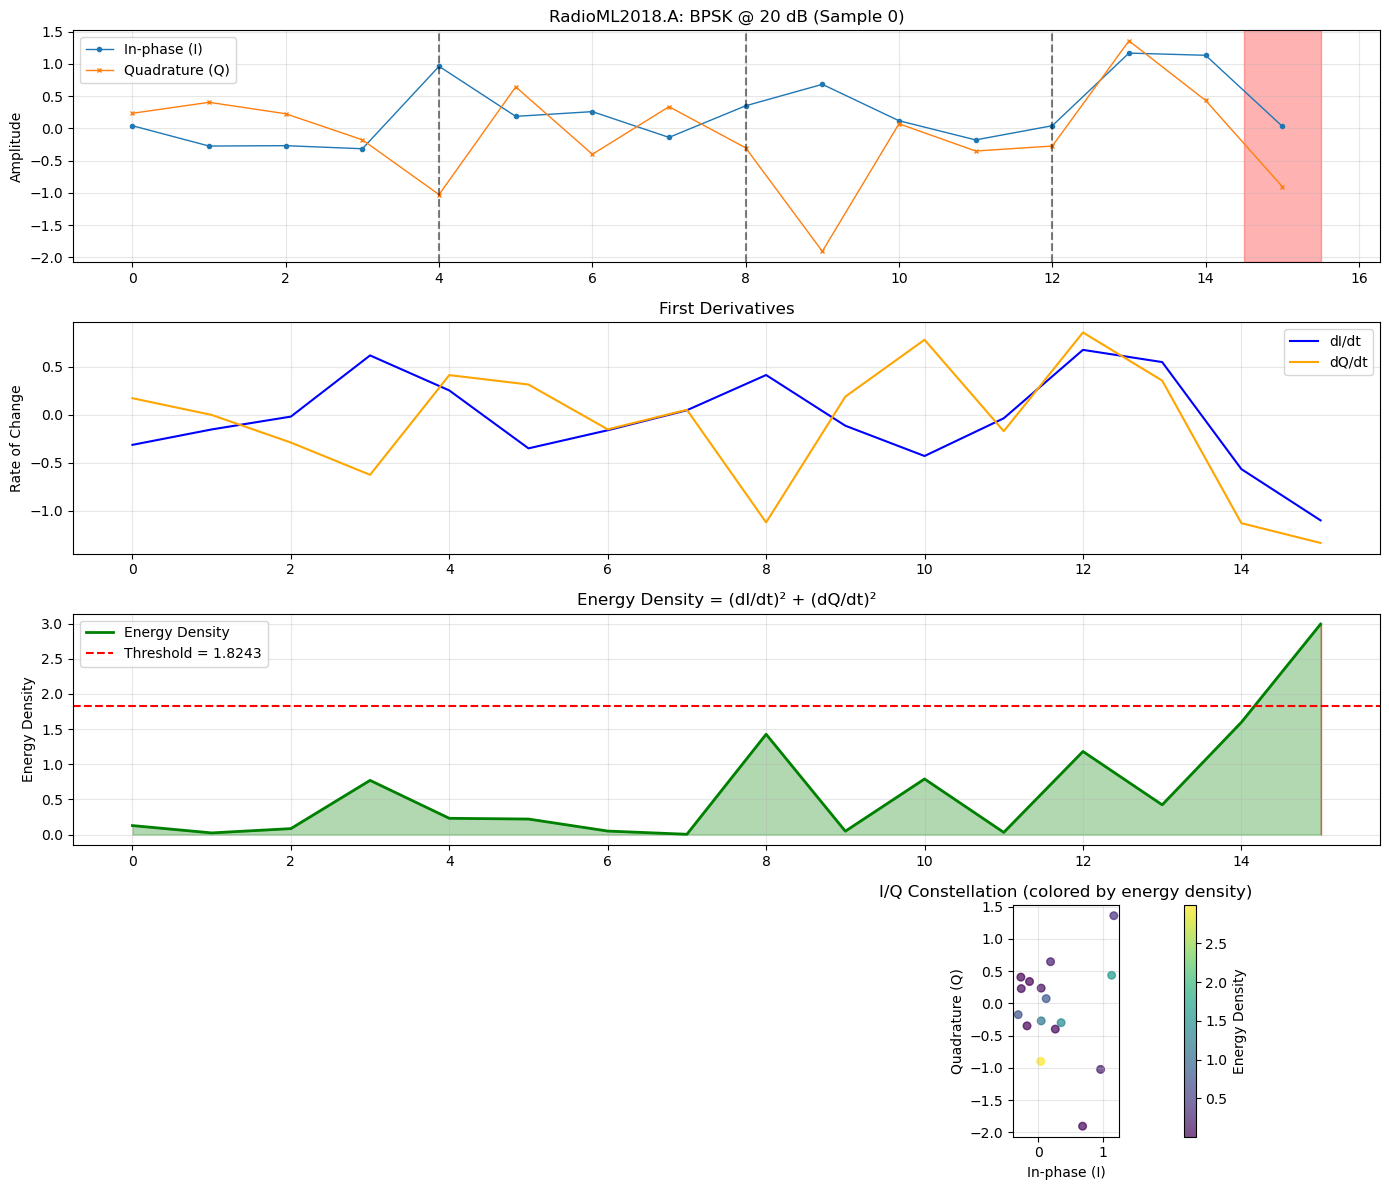


=== Energy Analysis Results ===
Modulation: BPSK
SNR: 20 dB
Sample Index: 0
Samples analyzed: 16
Estimated samples per symbol: 4
Symbol periods: 4
Total Energy: 8.44899464
Transition Energy: 0.00000000
Transition Energy Ratio: 0.00%
Number of high-energy samples: 1
Energy threshold: 1.82433558

=== Energy per Symbol Period ===
Symbol 1: 0.55855584
Symbol 2: 0.38935128
Symbol 3: 1.56851697
Symbol 4: 4.10859871
Analysis completed successfully!


/tmp/ipykernel_8749/1168177064.py:309: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  symbol_energy = np.trapz(energy_density[start_idx:end_idx])


In [14]:
if __name__ == "__main__":
    # Replace with your actual file path
    FILE_PATH = FILE_PATH  # Adjust based on your file
    
    print("Available modulations:", MODULATION_CLASSES)
    print("Available SNR levels:", SNR_RANGE)
    
    # Test with a single modulation first
    print(f"\n{'='*50}")
    print(f"Analyzing BPSK")
    print(f"{'='*50}")
    
    try:
        results = analyze_signal_energy_efficient(
            file_path=FILE_PATH,
            modulation='BPSK',
            snr_level=20,
            symbol_periods_to_plot=4,
            sample_index=0
        )
        
        if results:
            print("Analysis completed successfully!")
        
    except Exception as e:
        print(f"Error during analysis: {e}")
        import traceback
        traceback.print_exc()